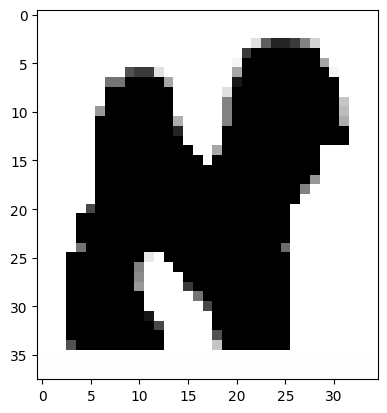

In [1]:
import sys 
sys.path.append("..")
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology, feature, segmentation, draw, color
from skimage.filters import threshold_local, sobel
from skimage.segmentation import active_contour, morphological_geodesic_active_contour, watershed
from synthetic import DataGenerator, SynthSettings
from alphabet import load_alphabet
from alphabet import A
from skimage.feature import peak_local_max
from matplotlib.patches import Rectangle
from scipy import ndimage as ndi

alphabet = load_alphabet()
single_letter = alphabet[A.Alef.value][3]
plt.imshow(single_letter, cmap="gray")

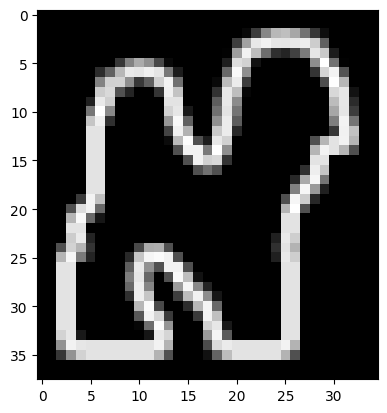

In [2]:
def sobel_edge(img):
    """Finding edges in an image using sobel filter"""
    return sobel(img.astype(float))

plt.imshow(sobel_edge(single_letter), cmap="gray")

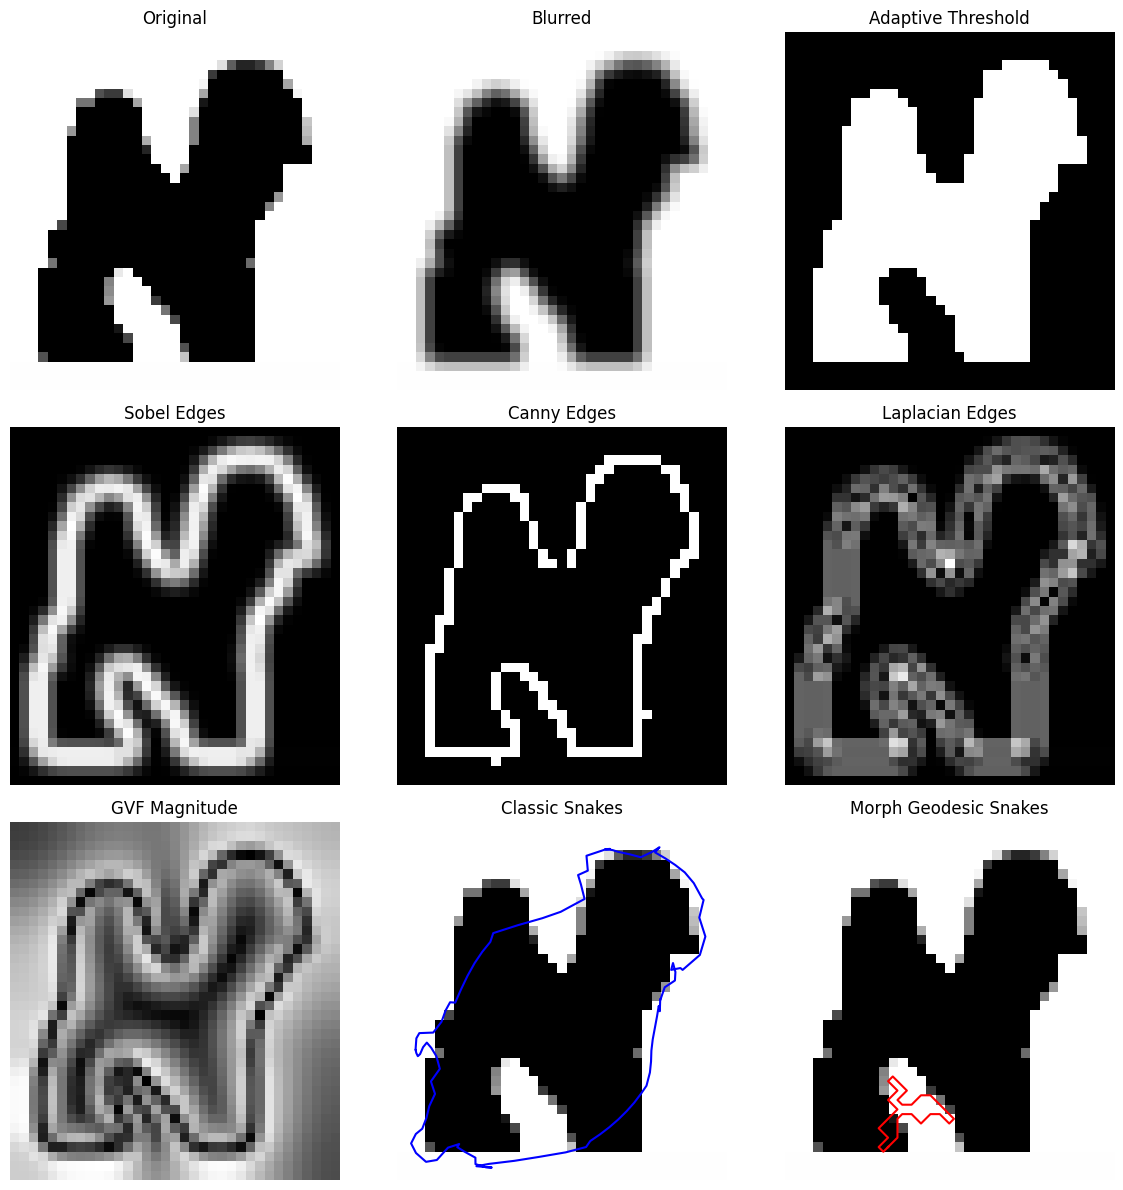

In [3]:


def sobel_edge(img):
    """Finding edges in an image using sobel filter"""
    return sobel(img.astype(float))

def canny_edge(img, sigma=1.0, low_threshold=None, high_threshold=None):
    """Compute Canny edges."""
    return feature.canny(img, sigma=sigma,
                         low_threshold=low_threshold,
                         high_threshold=high_threshold)

def laplacian_edge(img):
    """Compute Laplacian edge detection."""
    return cv2.Laplacian(img, cv2.CV_64F)

def compute_gvf(f, mu=0.2, max_iter=80, tol=1e-3):
    """Compute Gradient Vector Flow field for image f with convergence."""
    f_norm = (f - np.min(f)) / (np.max(f) - np.min(f) + 1e-8)
    fy, fx = np.gradient(f_norm)
    u, v = fx.copy(), fy.copy()
    mag2 = fx * fx + fy * fy
    for i in range(max_iter):
        u_prev, v_prev = u.copy(), v.copy()
        lap_u = cv2.Laplacian(u, cv2.CV_64F)
        lap_v = cv2.Laplacian(v, cv2.CV_64F)
        u = u + mu * lap_u - (u - fx) * mag2
        v = v + mu * lap_v - (v - fy) * mag2
        diff = np.linalg.norm(u - u_prev) + np.linalg.norm(v - v_prev)
        if diff < tol:
            break
    return u, v

# === Snake Segmentation Functions ===
def classical_snakes(img, regions, radius=20, num_points=100,
                    alpha=0.015, beta=10, gamma=0.001):
    """Run classical parametric snakes on Gaussian-smoothed image."""
    smoothed = filters.gaussian(img, sigma=1)
    snakes = []
    for region in regions:
        y0, x0 = region.centroid
        s = np.linspace(0, 2 * np.pi, num_points)
        r = y0 + radius * np.sin(s)
        c = x0 + radius * np.cos(s)
        init = np.vstack([r, c]).T
        snake = active_contour(smoothed, init,
                                alpha=alpha, beta=beta, gamma=gamma)
        snakes.append(snake)
    return snakes

def morph_geodesic_snakes(gmag, regions, radius=5, num_iter=200,
                          smoothing=0, balloon=1):
    """Run morphological geodesic active contours driven by gradient magnitude."""
    snakes = []
    for region in regions:
        y0, x0 = region.centroid
        y0, x0 = int(round(y0)), int(round(x0))  # Ensure integer indices

        init_ls = np.zeros_like(gmag, dtype=np.int8)
        rr, cc = draw.disk((y0, x0), radius=radius, shape=gmag.shape)
        init_ls[rr, cc] = 1

        snake_ls = morphological_geodesic_active_contour(
            gmag,
            num_iter=num_iter,
            init_level_set=init_ls,
            smoothing=smoothing,
            balloon=balloon
        )

        contours = measure.find_contours(snake_ls, 0.5)
        if contours:
            longest = max(contours, key=len)
            snakes.append(longest)
    return snakes

# === Main Pipeline ===
def segment_and_plot(image):
    
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    block_size = 35
    adaptive = threshold_local(blurred, block_size, offset=10)
    binary = blurred < adaptive
    clean = morphology.remove_small_objects(binary, min_size=50)
    labeled = measure.label(clean)
    regions = measure.regionprops(labeled)

    
    edge_sobel = sobel_edge(blurred)
    edge_canny = canny_edge(blurred, sigma=1.0)
    edge_laplacian = laplacian_edge(blurred)
    u, v = compute_gvf(edge_sobel)
    gmag = np.sqrt(u * u + v * v)
    gmag = (gmag - gmag.min()) / (gmag.max() - gmag.min() + 1e-8)

    
    snakes_classic = classical_snakes(blurred, regions)
    snakes_geo = morph_geodesic_snakes(gmag, regions)

    
    titles = ["Original", "Blurred", "Adaptive Threshold",
              "Sobel Edges", "Canny Edges", "Laplacian Edges", "GVF Magnitude",
              "Classic Snakes", "Morph Geodesic Snakes"]
    images = [image, blurred, clean,
              edge_sobel, edge_canny.astype(float), np.abs(edge_laplacian), gmag,
              image, image]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx], cmap='gray')
        ax.set_title(titles[idx])
        ax.axis('off')
        if titles[idx] == "Classic Snakes":
            for snake in snakes_classic:
                ax.plot(snake[:, 1], snake[:, 0], '-b')
        if titles[idx] == "Morph Geodesic Snakes":
            for cnt in snakes_geo:
                ax.plot(cnt[:, 1], cnt[:, 0], '-r')
    plt.tight_layout()
    plt.show()

# === Usage ===
image = alphabet[A.Alef.value][3]
segment_and_plot(image)


In [4]:
settings = SynthSettings()
generator = DataGenerator(settings=settings)

tokens, masks, images = generator.generate_ngram_scrolls(1)

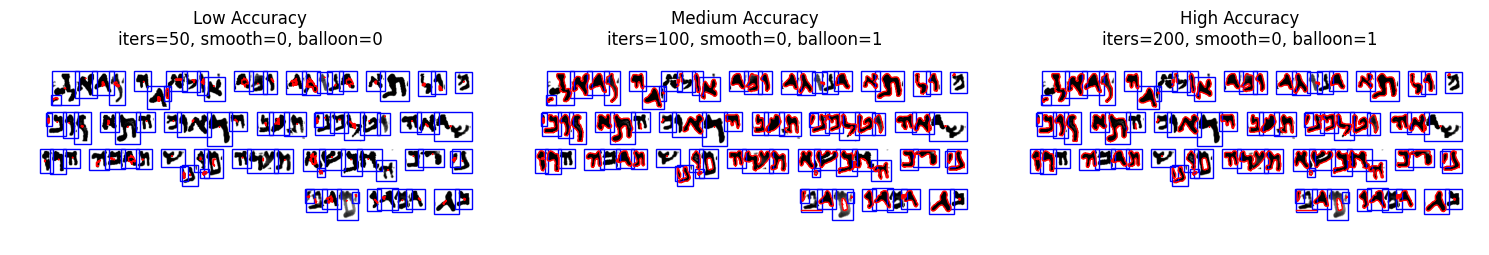

In [ ]:
def split_region_into_letters(label_img, region, min_dist=5):
    """Watershed‐split one regionprop into multiple RegionProps if needed."""
    minr, minc, maxr, maxc = region.bbox
    mask = (label_img[minr:maxr, minc:maxc] == region.label)

    dist = ndi.distance_transform_edt(mask)
    coords = peak_local_max(dist, min_distance=min_dist, labels=mask)
    local_max = np.zeros_like(mask, dtype=bool)
    if coords.shape[0] > 0:
        local_max[coords[:, 0], coords[:, 1]] = True
    markers, _ = ndi.label(local_max)
    ws = watershed(-dist, markers, mask=mask)

    new_regions = []
    for lbl in np.unique(ws):
        if lbl == 0:
            continue
        sub_full = np.zeros_like(label_img, dtype=int)
        sub_full[minr:maxr, minc:maxc][ws == lbl] = 1
        props = measure.regionprops(sub_full)
        if props:
            new_regions.append(props[0])
    return new_regions

def segment_contours_and_boxes(img, disk_radius, mgac_iter, smoothing, balloon, pad,
                               aspect_thresh=1.5, area_thresh=1000):
    """Run MGAC per-region and return padded bboxes (with watershed splitting). Morphological Geodesical Active Contours"""
    gray = img.astype(float) if img.ndim < 3 else color.rgb2gray(img)
    blur = filters.gaussian(gray, sigma=1)
    thr = filters.threshold_otsu(blur)
    clean = morphology.remove_small_objects(blur < thr, min_size=30)
    lbls = measure.label(clean)
    raw_regions = measure.regionprops(lbls)
    phi = 1.0 / (1.0 + sobel(blur))

    # collect final regions (split if needed)
    regions = []
    for r in raw_regions:
        h = r.bbox[2] - r.bbox[0]
        w = r.bbox[3] - r.bbox[1]
        if (w / h > aspect_thresh) or ((w * h) > area_thresh):
            split_regions = split_region_into_letters(lbls, r, min_dist=int(h / 2))
            if len(split_regions) >= 2:
                regions.extend(split_regions)
            else:
                regions.append(r)  # fallback: use original region if split fails
        else:
            regions.append(r)

    contours = []
    boxes = []

    for r in regions:
        minr, minc, maxr, maxc = r.bbox[:4]
        minr = max(minr - pad, 0)
        minc = max(minc - pad, 0)
        maxr = min(maxr + pad, gray.shape[0])
        maxc = min(maxc + pad, gray.shape[1])
        boxes.append((minr, minc, maxr, maxc))

        sub_phi = phi[minr:maxr, minc:maxc]
        init_ls = np.zeros_like(sub_phi, dtype=np.int8)
        cy = int(r.centroid[0] - minr)
        cx = int(r.centroid[1] - minc)
        rr, cc = draw.disk((cy, cx), radius=disk_radius, shape=sub_phi.shape)
        init_ls[rr, cc] = 1

        ls_sub = morphological_geodesic_active_contour(
            sub_phi,
            num_iter=mgac_iter,
            init_level_set=init_ls,
            smoothing=smoothing,
            balloon=balloon
        )
        ctrs = measure.find_contours(ls_sub, 0.5)
        if ctrs:
            c = max(ctrs, key=len) + np.array([minr, minc])
            contours.append(c)

    return contours, boxes

# --- Usage ---
param_sets = [
    {"label": "Low",    "disk_radius": 2, "mgac_iter": 50,  "smoothing": 0, "balloon": 0, "pad": 5},
    {"label": "Medium", "disk_radius": 2, "mgac_iter": 100, "smoothing": 0, "balloon": 1, "pad": 5},
    {"label": "High",   "disk_radius": 2, "mgac_iter": 200, "smoothing": 0, "balloon": 1, "pad": 5},
]

fig, axes = plt.subplots(1, len(param_sets), figsize=(15, 5))
for ax, params in zip(axes, param_sets):
    ax.imshow(images[0], cmap='gray')
    ax.set_title(f"{params['label']} Accuracy\niters={params['mgac_iter']}, smooth={params['smoothing']}, balloon={params['balloon']}")
    ax.axis('off')

    ctrs, boxes = segment_contours_and_boxes(
        images[0],
        disk_radius=params['disk_radius'],
        mgac_iter=params['mgac_iter'],
        smoothing=params['smoothing'],
        balloon=params['balloon'],
        pad=params["pad"]
    )

    for (minr, minc, maxr, maxc) in boxes:
        rect = Rectangle(
            (minc, minr), maxc - minc, maxr - minr,
            edgecolor='blue', facecolor='none', linewidth=1
        )
        ax.add_patch(rect)

    for c in ctrs:
        ax.plot(c[:, 1], c[:, 0], '-r', lw=1)

plt.tight_layout()
plt.savefig('letter_segmentation_with_rois.png', dpi=300, bbox_inches='tight')
plt.show()
